In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests

Longitud del texto: 5000, vocabulario: 53

=== Experimento 1 ===


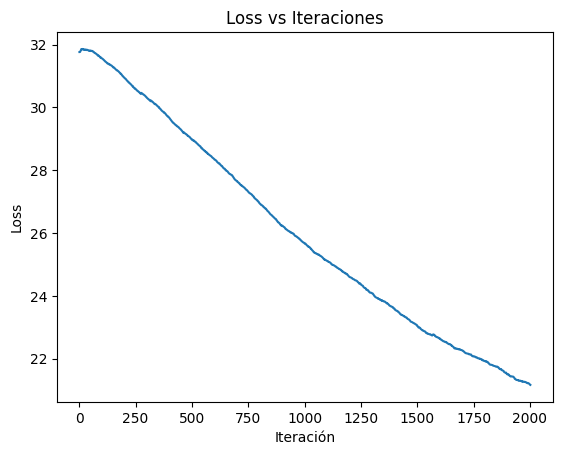

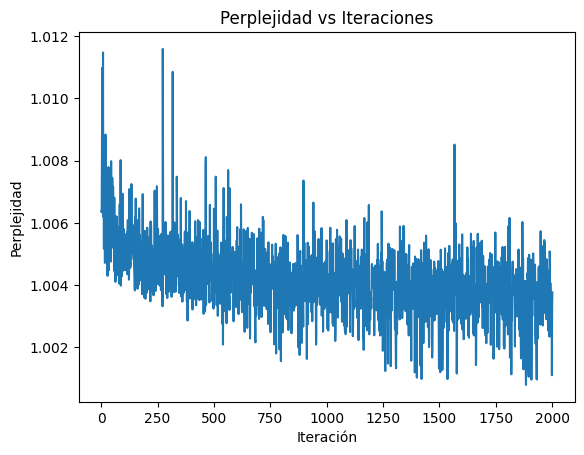

→ Texto generado:

Meld, thes toll-eprotar an kot anstnner tur nonm
ite kisirpnot theld entous curpeos reace tiay Cit zeme the fow; urte furctiesves aps aisecor your po' woft pfou peallengureices erare thwirste Wh ded ped sogr:
Wot ciand? noedeins de thes bas bnos youll, weousandarliunteyroicing ant Nu ar; re withes:

=== Experimento 2 ===


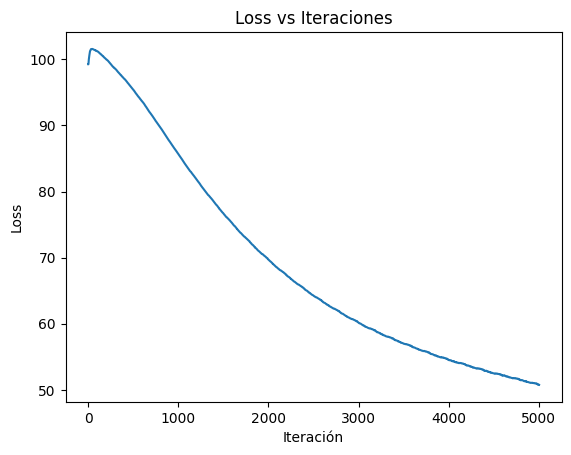

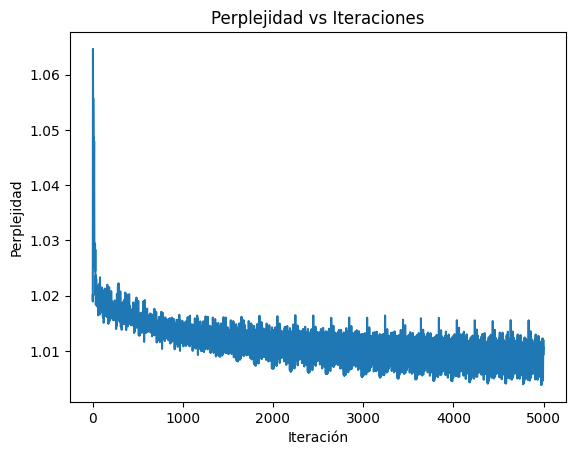

→ Texto generado:
n cent, Cyote epapfarle engs. 
hato foure citizencYourd the kegit yould red yo shtate tanly walid not there sominctat diesecos he cpitr
zerb, tharst the your couserel:
See: in ond cigimed nge'enoy
Lekilk dit to pioup, whith es, enele thald e tid meaken:
Fhoin tit, my th wh fpeatl-!
Tirc ou'de, wead,

=== Experimento 3 ===


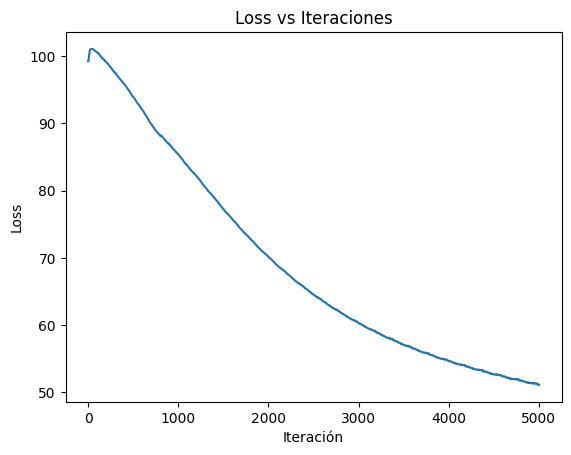

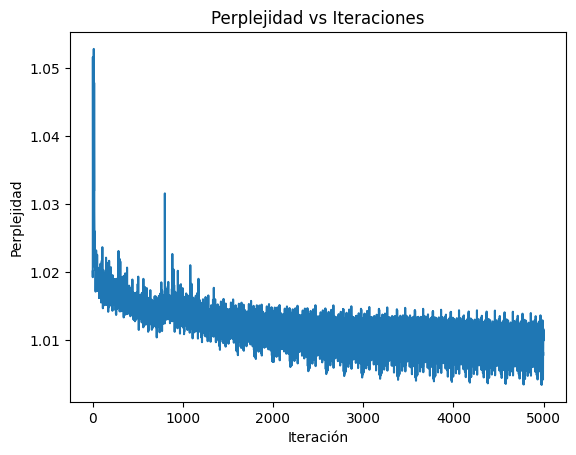

→ Texto generado:
d fored it to the pier pemt;
Yon usfcoflll wititod, y
thesweds sers matain; the he whawe feaw Ciu noud, moopeell.
Wrour, prud usmyowid iapaot Eitizin:
it, cod culd.

in bit whe
go erus, ito-y's liny, mave pood oril tituwitherenood rot on neace
it oucoon swe
beln:
surcond, witk se-t the sers yoir tur

=== Experimento 4 ===


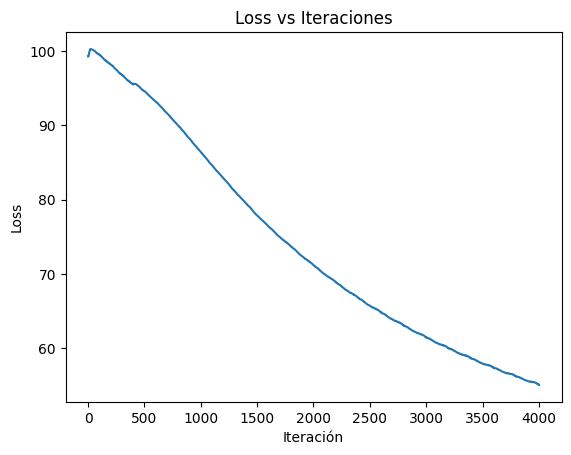

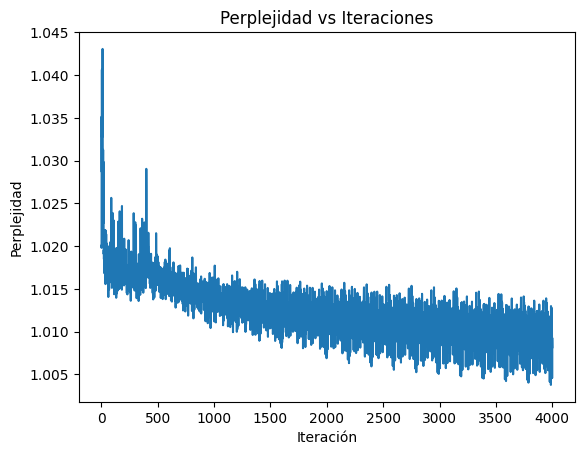

→ Texto generado:
Yot
Toat thind buthe anstiy rsingne kius if ratherree gien:
Ore bun ws
you. se w
in stilrto muris. hatr alf,
whuange anoknh'st helisd
izer citizen:
Selk ve litize helire; yitizen.

First ave.

HMENENEiIU, tize
MSod cithe habe then anci'd!yr: go, meacd as
y ehirle: bell

Firl ant, d.

Fr sor ange.
Th

=== Experimento 5 ===


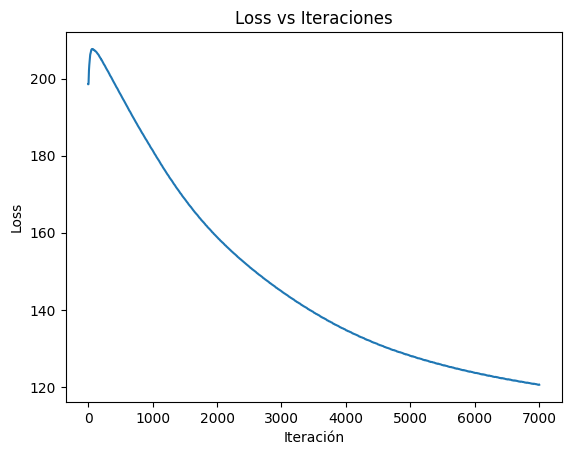

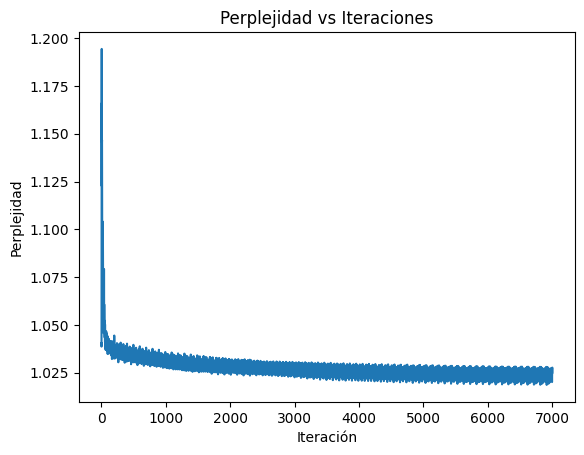

→ Texto generado:
eahey Ceasraadecarny donen:t:! undamhor yoil fot mos dies mEthe titireseay thirtoret sempamiOs ss wh hot toto muz uithineethe ine anchit you the wou In ofcin titour yet

Felet
Youl me
Ypiw ne Lititosf bly  tf
Werlheat me siver un ear these chl
I be a dirr
eot thesatreides sipon cas?

f: eg fr!ourtli

=== Experimento 6 ===


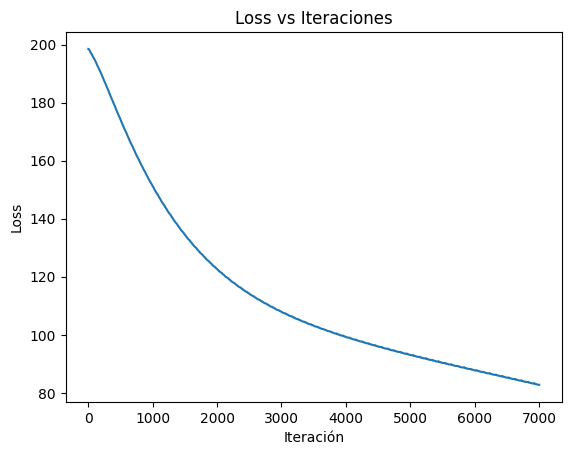

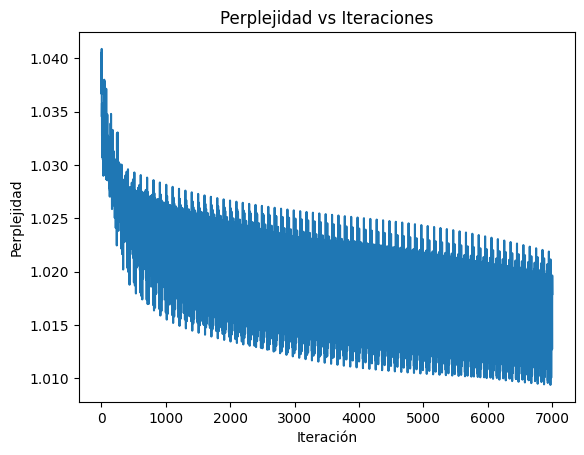

→ Texto generado:
fonlus,
youg anverod o

oursey, hirisusm the gvet tonemb meseds, mured of eritins, thit Cotizen:
Whet heslics,
Fursmin hinn torest them
Asties lo berricho ita nemusd?

Ael:
Swit, hMall
no'd aid: seay.

First Cimines:
You hisp r; usurthen tor silius winuaysinkest ve fir jou' thet fad asuetf, mant wem


In [5]:
# ---------------------------------------------------------------------
# Cargar texto tiny Shakespeare
# ---------------------------------------------------------------------
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
text = requests.get(url).text[:5000]   # usa solo los primeros 5000 caracteres para que sea más rápido

chars = list(set(text))
data_size, vocab_size = len(text), len(chars)
print(f"Longitud del texto: {data_size}, vocabulario: {vocab_size}")

# Diccionarios char↔int
char_to_int = {ch: i for i, ch in enumerate(chars)}
int_to_char = {i: ch for i, ch in enumerate(chars)}

# ---------------------------------------------------------------------
# Clase RNN: generacion de textos
# ---------------------------------------------------------------------
class vanillaRNN:
    def __init__(self, n_x, n_h, seq_length, learning_rate):
        self.n_x = n_x
        self.n_h = n_h
        self.seq_length = seq_length
        self.learning_rate = learning_rate
        
        self.Wxh = np.random.randn(n_h, n_x) * 0.01
        self.Whh = np.random.randn(n_h, n_h) * 0.01
        self.Why = np.random.randn(n_x, n_h) * 0.01
        self.bh = np.zeros((n_h, 1))
        self.by = np.zeros((n_x, 1))
        
        self.mWxh = np.zeros_like(self.Wxh)
        self.mWhh = np.zeros_like(self.Whh)
        self.mWhy = np.zeros_like(self.Why)
        self.mbh = np.zeros_like(self.bh)
        self.mby = np.zeros_like(self.by)

    def forward_pass(self, inputs, targets, hprev):
        x, h, y, p = {}, {}, {}, {}
        h[-1] = np.copy(hprev)
        loss = 0
        for t in range(len(inputs)):
            x[t] = np.zeros((self.n_x, 1))
            x[t][inputs[t]] = 1
            h[t] = np.tanh(self.Wxh @ x[t] + self.Whh @ h[t-1] + self.bh)
            y[t] = self.Why @ h[t] + self.by
            p[t] = np.exp(y[t]) / np.sum(np.exp(y[t]))
            loss -= np.log(p[t][targets[t], 0])
        return loss, x, h, p

    def backpropagation(self, x, h, p, targets, *, do_clipping):
        dWxh, dWhy, dWhh = np.zeros_like(self.Wxh), np.zeros_like(self.Why), np.zeros_like(self.Whh)
        dbh, dby = np.zeros_like(self.bh), np.zeros_like(self.by)
        dhnext = np.zeros_like(h[0])
        for t in reversed(range(self.seq_length)):
            dy = np.copy(p[t])
            dy[targets[t]] -= 1
            dWhy += dy @ h[t].T
            dby += dy
            dh = self.Why.T @ dy + dhnext
            dhraw = (1 - h[t] * h[t]) * dh
            dbh += dhraw
            dWxh += dhraw @ x[t].T
            dWhh += dhraw @ h[t-1].T
            dhnext = self.Whh.T @ dhraw
        if do_clipping:
            for dpara in [dWxh, dWhh, dWhy, dby, dbh]:
                np.clip(dpara, -5, 5, out=dpara)
        return dWxh, dWhh, dWhy, dbh, dby

    def update_para(self, dWxh, dWhh, dWhy, dbh, dby):
        for para, dpara, mem in zip(
            ['Wxh', 'Whh', 'Why', 'bh', 'by'],
            [dWxh, dWhh, dWhy, dbh, dby],
            ['mWxh', 'mWhh', 'mWhy', 'mbh', 'mby']):
            setattr(self, mem, getattr(self, mem) + dpara * dpara)
            setattr(self, para, getattr(self, para) -
                    self.learning_rate * dpara / np.sqrt(getattr(self, mem) + 1e-8))

    def make_sample(self, hprev, seed_ix, n):
        x = np.zeros((self.n_x, 1))
        x[seed_ix] = 1
        ixes, h = [], np.copy(hprev)
        for t in range(n):
            h = np.tanh(self.Wxh @ x + self.Whh @ h + self.bh)
            y = self.Why @ h + self.by
            p = np.exp(y) / np.sum(np.exp(y))
            ix = np.random.choice(range(self.n_x), p=p.ravel())
            x = np.zeros((self.n_x, 1))
            x[ix] = 1
            ixes.append(ix)
        return ixes

    def plot(self, values, tipo):
        plt.plot(range(1, len(values) + 1), values)
        plt.title(f'{tipo} vs Iteraciones')
        plt.xlabel('Iteración')
        plt.ylabel(tipo)
        plt.show()

    def train(self, inputs, char_to_int, int_to_char, max_iter=2000, *,
              do_plot_loss=True, do_plot_perplexity=True, do_clipping=True):
        iter_num, pos = 0, 0
        loss_hist, perplex_hist = [], []
        loss_hist.append(- np.log(1 / self.n_x) * self.seq_length)
        hprev = np.zeros((self.n_h, 1))
        while iter_num <= max_iter:
            if pos + self.seq_length + 1 >= len(inputs):
                pos = 0
                hprev = np.zeros((self.n_h, 1))
            batch_in = [char_to_int[ch] for ch in inputs[pos:pos + self.seq_length]]
            batch_out = [char_to_int[ch] for ch in inputs[pos + 1:pos + self.seq_length + 1]]
            pos += self.seq_length
            loss, x, h, p = self.forward_pass(batch_in, batch_out, hprev)
            loss_hist.append(loss_hist[-1] * 0.999 + loss * 0.001)
            perplex_hist.append(np.exp(loss / len(inputs)))
            dWxh, dWhh, dWhy, dbh, dby = self.backpropagation(x, h, p, batch_out, do_clipping=do_clipping)
            self.update_para(dWxh, dWhh, dWhy, dbh, dby)
            hprev = h[self.seq_length - 1]
            iter_num += 1
        # sample
        sample_ix = self.make_sample(hprev, batch_out[-1], 300)
        texto = ''.join(int_to_char[ix] for ix in sample_ix)
        if do_plot_loss:
            self.plot(loss_hist, "Loss")
        if do_plot_perplexity:
            self.plot(perplex_hist, "Perplejidad")
        return loss_hist, texto, perplex_hist

# ---------------------------------------------------------------------
# Experimentos con distintos hiperparámetros
# ---------------------------------------------------------------------
configs = [
    # 1. Modelo pequeño y secuencia corta
    {"n_h": 50, "seq_length": 8, "max_iter": 2000,
     "lr": 1e-1, "clip": True},

    # 2. Modelo mediano y secuencia larga
    {"n_h": 100, "seq_length": 25, "max_iter": 5000,
     "lr": 1e-1, "clip": True},

    # 3. Igual al anterior pero sin gradient clipping
    {"n_h": 100, "seq_length": 25, "max_iter": 5000,
     "lr": 1e-1, "clip": False},

    # 4. Conjunto de datos reducido al 20%
    {"n_h": 100, "seq_length": 25, "max_iter": 4000,
     "lr": 1e-1, "clip": True, "dataset_percent": 0.2},

    # 5. Modelo grande y secuencia extensa
    {"n_h": 200, "seq_length": 50, "max_iter": 7000,
     "lr": 1e-1, "clip": True},

    # 6. Modelo grande con tasa de aprendizaje reducida
    {"n_h": 200, "seq_length": 50, "max_iter": 7000,
     "lr": 1e-2, "clip": True},
]



for i, cfg in enumerate(configs, 1):
    print(f"\n=== Experimento {i} ===")
    rnn = vanillaRNN(n_x=vocab_size, n_h=cfg["n_h"], seq_length=cfg["seq_length"], learning_rate=cfg["lr"])
    loss_hist, texto, perplex = rnn.train(
        text, char_to_int, int_to_char,
        max_iter=cfg["max_iter"], do_clipping=cfg["clip"]
    )
    print(f"→ Texto generado:\n{texto[:500]}")
